<a href="https://colab.research.google.com/github/DaveLoay/AP_Tarea_2/blob/main/AP_T2_E2_PT2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Usando transferencia de conocimiento, entrenar un modelo reentrenando solo la última capa.

In [27]:
# biblioteca para inspeccionar arquitecturas
# https://github.com/tyleryep/torchinfo
# Colab
!pip install torch-summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [28]:
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [29]:
# funciones aleatorias
import random
# tomar n elementos de una secuencia
from itertools import islice as take
# sistema de archivos
import os

# gráficas
import matplotlib.pyplot as plt
# arreglos multidimensionales
import numpy as np
# csv
import pandas as pd
# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets.utils as tvutils
# imágenes
from skimage import io
from skimage.transform import resize
# redes neuronales
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
# inspección de arquitectura
# https://github.com/TylerYep/torch-summary
from torchsummary import summary
# barras de progreso
from tqdm import tqdm
# imágenes
from PIL import Image

In [30]:
# directorio de datos
URL = 'https://cloud.xibalba.com.mx/s/QpJdJ5aLEDG9Ryb/download'
base_dir = '../data/face'
filename = 'UTKFace.tar.gz'
data_dir = '../data/face/UTKFace'
filepath = os.path.join(base_dir, filename)

# tamaño del lote
BATCH_SIZE = 32
# filas y columnas de la rejilla de imágenes
ROWS, COLS = 4, 8
# tamaño de la imagen
IMG_SIZE = 64


def crop_center(img, cropx, cropy):
    y, x = img.shape[:2]
    startx = x // 2 - cropx // 2
    starty = y // 2 - cropy // 2    
    return img[starty:starty+cropy, startx:startx+cropx]


def display_grid(xs, titles, rows, cols, figsize=(12, 6)): 
    """Displays examples in a grid."""
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    i = 0
    for r in range(rows):
        for c in range(cols):
            ax[r, c].imshow(xs[i])
            ax[r, c].set_title(titles[i])
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
            i += 1
    fig.tight_layout()
    plt.show()


def display_batch(x, titles, rows, cols, figsize=(12, 6)):
    """Displays a batch of processed examples in a grid."""
    x *= 255
    x = x.permute(0, 2, 3, 1)
    # convertimos a entero
    x = (x.numpy()).astype(np.uint8)
    display_grid(x, titles, rows, cols, figsize)

def timestamp(fmt='%y%m%dT%H%M%S'):
    """Regresa la marca de tiempo."""
    return datetime.datetime.fromtimestamp(time.time()).strftime(fmt)


def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


def numpy_to_torch(x):
    x = transforms.functional.to_tensor(x)
    x = x.type(torch.float32)
    return x


# reproducibilidad
set_seed()

In [31]:
! mkdir -p {base_dir}
! wget -nc {URL} -O {filepath}
! tar -zxf {filepath} -C {base_dir}

File ‘../data/face/UTKFace.tar.gz’ already there; not retrieving.


In [32]:
images = []
age = []
images_path_names = []

for img in os.listdir(data_dir):
  ages = img.split("_")[0]
  genders = img.split("_")[1]
  images.append(np.array(img))
  age.append(np.array(ages))
  image_path = os.path.join(base_dir, img)
  images_path_names.append(image_path)

age = np.array(age,dtype=np.int64)
images = np.array(images)
images_path_names = np.array(images_path_names)

In [33]:
from sklearn.model_selection import train_test_split
imgs_train, imgs_test, ages_train, ages_test =  train_test_split(images, age, test_size = 0.2, random_state = 0 )

In [34]:
# Training DataSet
imgs_train = pd.Series(imgs_train, name = 'Image')
ages_train = pd.Series(ages_train, name = 'Age')
df_train = pd.concat([imgs_train,ages_train],axis = 1)
print(df_train.shape)
df_train.head()

(18966, 2)


,Image,Age
0,28_0_3_20170104220258078.jpg.chip.jpg,28
1,23_1_0_20170117145105755.jpg.chip.jpg,23
2,31_1_0_20170117133158992.jpg.chip.jpg,31
3,67_1_0_20170120224807800.jpg.chip.jpg,67
4,28_1_3_20170104235045746.jpg.chip.jpg,28


In [35]:
# Test DataSet
imgs_test = pd.Series(imgs_test, name = 'Image')
ages_test = pd.Series(ages_test, name = 'Age')
df_test = pd.concat([imgs_test,ages_test],axis = 1)
print(df_test.shape)
df_test.head()

(4742, 2)


,Image,Age
0,17_0_1_20170116182122450.jpg.chip.jpg,17
1,26_0_0_20170117172146059.jpg.chip.jpg,26
2,18_1_1_20170116211857195.jpg.chip.jpg,18
3,55_0_0_20170120222449816.jpg.chip.jpg,55
4,21_1_0_20170116220220347.jpg.chip.jpg,21


In [36]:
# Creando Archivos .csv de los dataframes
from pathlib import Path  

filepath_train = Path(os.path.join(base_dir,'faces_train.csv'))  
filepath_train.parent.mkdir(parents=True, exist_ok=True)
df_train.to_csv(filepath_train)

filepath_test = Path(os.path.join(base_dir,'faces_test.csv'))  
filepath_test.parent.mkdir(parents=True, exist_ok=True)
df_test.to_csv(filepath_test)

In [37]:
from torch.utils.data.distributed import Dataset
from torchvision.io import read_image

class loayDS(Dataset):

  def __init__(self, csvfile, img_dir, transform):
    df = pd.read_csv(os.path.join(img_dir, csvfile))
    df_l = df['Image'].tolist()
    self.img_labels = []
    self.img_dir = []
    self.transform = transform
    for img in df_l:
      name = os.path.join(img_dir, img)
      self.img_labels.append(img.split("_")[0])
      self.img_dir.append(name)

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, index):
    img_path = self.img_dir[index]
    image = Image.open(img_path)
    image = self.transform(image)
    label = np.array(self.img_labels[index], np.int64)
    
    return image, label

Feature batch shape: torch.Size([32, 3, 64, 64]) dtypetorch.float32
Labels batch shape: torch.Size([32]) dtypetorch.int64


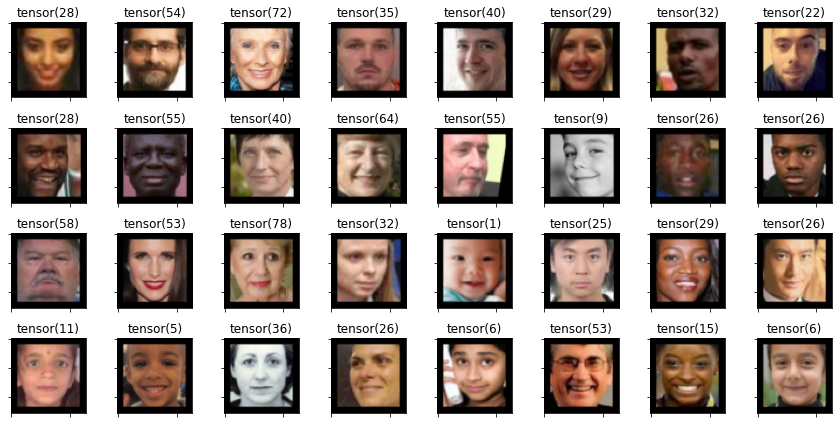

In [38]:
transform = transforms.Compose([
    transforms.CenterCrop(240),
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    ])

csv_train = "/data/face/faces_train.csv"
csv_test = "/data/face/faces_test.csv"

train_ds = loayDS(csv_train,data_dir,transform)
test_ds = loayDS(csv_test,data_dir,transform)

train_dataloader = DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle = True)
test_dataloader = DataLoader(test_ds, batch_size = BATCH_SIZE, shuffle = True)

train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.shape} dtype{train_features.dtype}")
print(f"Labels batch shape: {train_labels.shape} dtype{train_labels.dtype}")
display_batch(train_features, train_labels, ROWS, COLS)

In [39]:
import datetime
import time
# tomar n elementos de una secuencia
from itertools import islice as take
# sistema de archivos
from os.path import join

In [40]:
import torchvision.datasets.utils as tvu
import torchvision.models as tvm

#Creando Dataloader para tranfer learning

trn_dl_tl = DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle = True, num_workers=4)
tst_dl_tl = DataLoader(test_ds, batch_size = BATCH_SIZE, shuffle = True, num_workers=4)


model = tvm.shufflenet_v2_x0_5(pretrained=True)
model

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weigh

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_

In [41]:
# congelamos los parámetros
for param in model.parameters():
    # no participa en la retropropagación
    param.requires_grad = False
# congelamos las estadísticas
model.eval()

# remplazo de última capa
model.fc = nn.Linear(1024, 117)

# inspección
summary(model, (3, 64, 64), device='cpu', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 24, 32, 32]          --
|    └─Conv2d: 2-1                       [-1, 24, 32, 32]          (648)
|    └─BatchNorm2d: 2-2                  [-1, 24, 32, 32]          (48)
|    └─ReLU: 2-3                         [-1, 24, 32, 32]          --
├─MaxPool2d: 1-2                         [-1, 24, 16, 16]          --
├─Sequential: 1-3                        [-1, 48, 8, 8]            --
|    └─InvertedResidual: 2-4             [-1, 48, 8, 8]            --
|    |    └─Sequential: 3-1              [-1, 24, 8, 8]            (888)
|    |    └─Sequential: 3-2              [-1, 24, 8, 8]            (1,512)
|    └─InvertedResidual: 2-5             [-1, 48, 8, 8]            --
|    |    └─Sequential: 3-3              [-1, 24, 8, 8]            (1,512)
|    └─InvertedResidual: 2-6             [-1, 48, 8, 8]            --
|    |    └─Sequential: 3-4              [-1, 24, 8, 8]            

In [48]:
# barra de progreso
from tqdm.auto import trange

def train_epoch(dl, model, opt, device):
    """Entrena una época"""
    # entrenamiento de una época
    
    for x, y_true in dl:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        x = x.to(device)
        y_true = y_true.to(device)
        # computamos logits
        y_lgts = model(x)
        # computamos la pérdida
        loss = F.cross_entropy(y_lgts, y_true)
        # vaciamos los gradientes
        opt.zero_grad()
        # retropropagamos
        loss.backward()
        # actualizamos parámetros
        opt.step()

def eval_epoch(dl, model, device, num_batches=None):
    """Evalua una época"""
    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad():
        
        losses, accs = [], []
        # validación de la época con num_batches
        # si num_batches==None, se usan todos los lotes
        for x, y_true in dl: 
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            x = x.to(device)
            y_true = y_true.to(device)
            # hacemos inferencia para obtener los logits
            y_lgts = model(x)
            # computamos las probabilidades
            y_prob = F.softmax(y_lgts, 1)
            # obtenemos la clase predicha
            y_pred = torch.argmax(y_prob, 1)
            
            # computamos la pérdida
            loss = F.cross_entropy(y_lgts, y_true)
            # computamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item())
            accs.append(acc.item())

        loss = np.mean(losses) * 100
        acc = np.mean(accs) * 100
        
        return loss, acc

def save_check_point(model, epoch, run_dir):
    """Guarda un punto de control."""
    torch.save(
        {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
        }, 
        join(run_dir, 'weights.pth')
    )

def train(model, trn_dl, val_dl, epochs=5,
          trn_batches=None, val_batches=None):

    loss_hist, acc_hist = [], []
    # optimizador
    opt = optim.Adam(model.parameters(), lr=1e-2)

    # usamos GPU si está disponible
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # movemos a dispositivo
    model.to(device)
    
    # modelo en modo de evaluación
    # para transferencia de conocimiento además de congelar los pesos, 
    # es importante congelar las estadísticas σ y μ 
    model.eval()

    # ciclo de entrenamiento
    best_acc = 0
    for epoch in range(epochs):

        # entrenamos la época
        train_epoch(trn_dl, model, opt, device)
        trn_loss, trn_acc = eval_epoch(trn_dl, model, trn_batches)

        # evaluamos la época en entrenamiento
        trn_loss, trn_acc = eval_epoch(trn_dl, model, device, trn_batches)

        # evaluamos la época en validación
        val_loss, val_acc = eval_epoch(val_dl, model, device, val_batches)
        
        loss_hist.append(trn_loss)
        acc_hist.append(trn_acc)

        # imprimimos progreso
        print(f'E{epoch:02} loss={trn_loss:6.2f} acc={trn_acc:5.2f}')
        

In [49]:
# entrenamos modelo
train(model, trn_dl_tl, tst_dl_tl, epochs=20, trn_batches=5, val_batches=5)

KeyboardInterrupt: ignored

# Usando transferencia de conocimiento, entrenar un modelo reentrenando toda la red.

In [50]:
model = tvm.shufflenet_v2_x0_5(pretrained=True)
model

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X0_5_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X0_5_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_

In [51]:
# remplazo de última capa
model.fc = nn.Linear(1024, 117)

# inspección
summary(model, (3, 64, 64), device='cpu', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 24, 32, 32]          --
|    └─Conv2d: 2-1                       [-1, 24, 32, 32]          648
|    └─BatchNorm2d: 2-2                  [-1, 24, 32, 32]          48
|    └─ReLU: 2-3                         [-1, 24, 32, 32]          --
├─MaxPool2d: 1-2                         [-1, 24, 16, 16]          --
├─Sequential: 1-3                        [-1, 48, 8, 8]            --
|    └─InvertedResidual: 2-4             [-1, 48, 8, 8]            --
|    |    └─Sequential: 3-1              [-1, 24, 8, 8]            888
|    |    └─Sequential: 3-2              [-1, 24, 8, 8]            1,512
|    └─InvertedResidual: 2-5             [-1, 48, 8, 8]            --
|    |    └─Sequential: 3-3              [-1, 24, 8, 8]            1,512
|    └─InvertedResidual: 2-6             [-1, 48, 8, 8]            --
|    |    └─Sequential: 3-4              [-1, 24, 8, 8]            1,512
|   

In [53]:
# barra de progreso
from tqdm.auto import trange

def train_epoch(dl, model, opt, device):
    """Entrena una época"""
    # entrenamiento de una época
    
    for x, y_true in dl:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        x = x.to(device)
        y_true = y_true.to(device)
        # computamos logits
        y_lgts = model(x)
        # computamos la pérdida
        loss = F.cross_entropy(y_lgts, y_true)
        # vaciamos los gradientes
        opt.zero_grad()
        # retropropagamos
        loss.backward()
        # actualizamos parámetros
        opt.step()

def eval_epoch(dl, model, device, num_batches=None):
    """Evalua una época"""
    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad():
        
        losses, accs = [], []
        # validación de la época con num_batches
        # si num_batches==None, se usan todos los lotes
        for x, y_true in dl: 
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            x = x.to(device)
            y_true = y_true.to(device)
            # hacemos inferencia para obtener los logits
            y_lgts = model(x)
            # computamos las probabilidades
            y_prob = F.softmax(y_lgts, 1)
            # obtenemos la clase predicha
            y_pred = torch.argmax(y_prob, 1)
            
            # computamos la pérdida
            loss = F.cross_entropy(y_lgts, y_true)
            # computamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item())
            accs.append(acc.item())

        loss = np.mean(losses) * 100
        acc = np.mean(accs) * 100
        
        return loss, acc

def save_check_point(model, epoch, run_dir):
    """Guarda un punto de control."""
    torch.save(
        {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
        }, 
        join(run_dir, 'weights.pth')
    )

def train(model, trn_dl, val_dl, epochs=5,
          trn_batches=None, val_batches=None):

    loss_hist, acc_hist = [], []
    # optimizador
    opt = optim.Adam(model.parameters(), lr=1e-2)

    # usamos GPU si está disponible
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # movemos a dispositivo
    model.to(device)
    
    # modelo en modo de evaluación
    # para transferencia de conocimiento además de congelar los pesos, 
    # es importante congelar las estadísticas σ y μ 
    model.eval()

    # ciclo de entrenamiento
    best_acc = 0
    for epoch in range(epochs):

        # entrenamos la época
        train_epoch(trn_dl, model, opt, device)
        trn_loss, trn_acc = eval_epoch(trn_dl, model, trn_batches)

        # evaluamos la época en entrenamiento
        trn_loss, trn_acc = eval_epoch(trn_dl, model, device, trn_batches)

        # evaluamos la época en validación
        val_loss, val_acc = eval_epoch(val_dl, model, device, val_batches)

        loss_hist.append(trn_loss)
        acc_hist.append(trn_acc)

        # imprimimos progreso
        print(f'E{epoch:02} loss={trn_loss:6.2f} acc={trn_acc:5.2f}')

In [ ]:
# entrenamos modelo
train(model, trn_dl_tl, tst_dl_tl, epochs=20, trn_batches=5, val_batches=5)

E00 loss=409.95 acc= 9.25
E01 loss=408.87 acc= 9.24
E02 loss=407.99 acc= 9.25


# Discusión

Comparando los dos métodos de transferencia de conocimiento, se observa que el fine tuning (eliminar la última capa del modelo), otorga mejores resultados en esta situación. Permite alcanzar mayores valores de exactitud además de que el tiempo de entranamiento y el costo computacional es menor.

Al igual que en los primeros incisos del ejercicio, el problema puede estar sesgado debido al desbalanceo en los datos.